In [314]:
import torch
import csv
import numpy as np
#%matplotlib ipympl
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import torch
from torch.optim import Adam
from torch.optim import SGD
import torch.nn as nn
from scipy import io

plt.ion()

In [349]:
filename = "simple-data.txt" # replace with your file name

material_names_to_ids = {}
coefficient_data = []
pairs = {}

num_materials = 0
with open(filename, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        def get_id(name):
            global num_materials
            if name not in material_names_to_ids:
                material_names_to_ids[name] = num_materials
                num_materials = num_materials+1
            return material_names_to_ids[name]
        pair_str = row[0]+"\t"+row[1]
        rev_pair_str = row[1]+"\t"+row[0]
        if pair_str in pairs or rev_pair_str in pairs :
            print(f"%s already exists, skipping!" % pair_str)
            continue
        pairs[pair_str] = True
        pairs[rev_pair_str] = True
        coefficient_data.append((get_id(row[0]),get_id(row[1]),float(row[2])))

Steel	Graphite already exists, skipping!
Wood	Brick already exists, skipping!


In [350]:
# extract the row indices, column indices, and values from the triplets
rows = [t[0] for t in coefficient_data]
cols = [t[1] for t in coefficient_data]
vals = [t[2] for t in coefficient_data]
# create a sparse matrix in COO format
coefficient_matrix = coo_matrix((vals, (rows, cols)),shape=(num_materials,num_materials))

In [357]:
def write_to_data_mat(coefficient_data, material_names_to_ids):
    materials = [key for (key) in material_names_to_ids]
    indices = np.array([(i, j) for (i, j, v) in coefficient_data])
    values = np.array([v for (i, j, v) in coefficient_data])
    # extract the coordinates from z using the indices
    # extract the row indices, column indices, and values from the triplets
    rows = [t[0] for t in coefficient_data]
    cols = [t[1] for t in coefficient_data]
    vals = [t[2] for t in coefficient_data]
    # create a sparse matrix in COO format
    coefficient_matrix = coo_matrix((vals, (rows, cols)),shape=(num_materials,num_materials))
    io.savemat('data.mat', {'indices': indices, 'values': values, "coefficient_matrix":coefficient_matrix,'materials': materials})
write_to_data_mat(coefficient_data,material_names_to_ids)

{'Aluminum': 0,
 'Mild Steel': 1,
 'Snow': 2,
 'Aluminum-bronze': 3,
 'Steel': 4,
 'Brake material2)': 5,
 'Cast iron': 6,
 'Cast iron (wet)': 7,
 'Brass': 8,
 'Brick': 9,
 'Wood': 10,
 'Cadmium': 11,
 'Chromium': 12,
 'Car tire': 13,
 'Asphalt': 14,
 'Grass': 15,
 'Carbon': 16,
 'Carbon (hard)': 17,
 'Cast Iron': 18,
 'Copper': 19,
 'Glass': 20,
 'Copper-Lead alloy': 21,
 'Cotton': 22,
 'Diamond': 23,
 'Metals': 24,
 'Metal': 25,
 'Nickel': 26,
 'Graphite': 27,
 'Hemp rope': 28,
 'Timber': 29,
 'Horseshoe': 30,
 'Concrete': 31,
 'Rubber': 32,
 'Ice': 33,
 'Iron': 34,
 'Leather': 35,
 'Clean Metal': 36,
 'Oak': 37,
 'Leather fiber': 38,
 'Magnesium': 39,
 'Masonry': 40,
 'Mica': 41,
 'Nylon': 42,
 'Oak (cross grain)': 43,
 'Oak (parallel grain)': 44,
 'Paper': 45,
 'Phosphor-bronze': 46,
 'Platinum': 47,
 'Plexiglas': 48,
 'Polyethylene': 49,
 'Polytehylene': 50,
 'Polystyrene': 51,
 'Polytetrafluoroethylene (PTFE)': 52,
 'Polytetrafluoroethylene (PTFE) (Teflon)': 53,
 'Cardboard': 54,

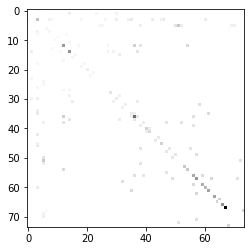

In [26]:
# plot the sparsity pattern
plt.imshow((coefficient_matrix+coefficient_matrix.T).todense(), cmap='binary', interpolation='nearest')
plt.show()

In [309]:
# define the initial values of z[i] and z[j]
log_z = torch.randn(num_materials, 1, requires_grad=True)

In [310]:
# define the optimizer
optimizer = Adam([log_z], lr=0.1)# define the loss function
#optimizer = SGD([log_z], lr=0.01, momentum=0.9)

In [311]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        w = 20
        self.layer1 = nn.Linear(2, w)
        self.layer2 = nn.Linear(w, w)
        self.layer3 = nn.Linear(w, w)
        self.layer4 = nn.Linear(w, w)
        self.layer5 = nn.Linear(w, w)
        self.layer6 = nn.Linear(w, w)
        #self.layer4 = nn.Linear(20, 20)
        self.last_layer = nn.Linear(w, 1)
        self.relu = nn.ReLU() # ReLU activation function

    def forward(self, zi, zj):
        # THIS DOES NOT WORK
        #x = torch.tensor([zi,zj],requires_grad=True)
        # YOU HAVE TO DO THIS?! DUH!
        x = torch.stack([zi, zj]).T
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        #x = self.relu(self.layer4(x))
        #x = self.relu(self.layer5(x))
        #x = self.relu(self.layer6(x))
        x = self.last_layer(x)
        return x
        #return torch.sqrt(x[0]*x[1])

In [312]:
def geomean(zi,zj):
    return torch.sqrt(zi * zj)

model = SimpleNet()

def f(zi,zj):
    return model.forward(zi,zj)
    #return geomean(zi,zj)

def loss_function(triplets, log_z):
    loss = 0
    z = torch.exp(log_z)
    for i, j, v in triplets:
        loss += torch.abs( f(z[i],z[j]) - v)
    return loss

In [313]:
# perform the optimization
num_epochs = 200000
batch_size = 16
#batch_size = len(coefficient_data)
for epoch in range(num_epochs):
    if epoch % 100 == 0:
        print(f"%d: %g (%g,%g)" % (epoch,loss_function(coefficient_data,log_z)/len(coefficient_data),torch.min(log_z),torch.max(log_z)))
    # shuffle the triplets for each epoch
    np.random.shuffle(coefficient_data)
    # iterate over mini-batches
    #for i in [1]:
    for i in range(0, len(coefficient_data), batch_size):
        batch_triplets = coefficient_data[i:i+batch_size]
        optimizer.zero_grad()
        loss = loss_function(batch_triplets, log_z)
        loss.backward()
        optimizer.step()    
    
# print the final values of z
#print(torch.exp(log_z).detach().numpy())

0: 0.286739 (-3.27926,1.7785)
100: 0.161077 (-6.19521,4.1127)
200: 0.149381 (-7.29768,4.12855)
300: 0.144357 (-8.00266,4.19757)
400: 0.143716 (-8.54546,4.09194)
500: 0.147792 (-9.00168,4.03563)
600: 0.146169 (-9.47837,4.03345)


KeyboardInterrupt: 

In [320]:
def write_to_data_mat(log_z):
    global coefficient_data
    indices = np.array([(i, j) for (i, j, v) in coefficient_data])
    values = np.array([v for (i, j, v) in coefficient_data])
    z = torch.exp(log_z).detach().numpy()
    x = np.linspace(0,1,10)
    y = np.linspace(0,1,10)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            Z[i,j] = f(torch.tensor(X[i,j]),torch.tensor(Y[i,j]))
    # extract the coordinates from z using the indices
    io.savemat('data.mat', {'z': z,'indices': indices, 'values': values,'X':X,'Y':Y,'Z':Z})

In [321]:
write_to_data_mat(log_z)

RuntimeError: expected scalar type Double but found Float

In [308]:
import sys

print(sys.executable)

/Users/alecjacobson/miniconda3/bin/python


In [12]:
print(sys.version)

3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
